# Parameter Estimation from ∆∆F

© 2019 Griffin Chure. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

--- 

In [77]:
import sys
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mut.thermo
import mut.bayes
import mut.viz
import pystan
colors = mut.viz.personal_style()
constants = mut.thermo.load_constants()

# Load the data. 
data = pd.read_csv('../../data/csv/compiled_data.csv')

# Load the Stan magic function for inference. 
%load_ext stanmagic

The stanmagic extension is already loaded. To reload it, use:
  %reload_ext stanmagic


In this notebook, we try to use the empirically calculated difference in the free energy of binding as a target for parameter estimation. Here, we consider all of the single mutants (DNA binding domain and inducer binding domain) and test if different combinations of parameters can capture the phenomenology of the induction profiles. 

As we have derived, the difference between the empirically determined change in binding free energy relative to an arbitrarily chosen reference state can be calculated as

$$
\Delta F^* - \Delta F = k_BT \left[ \log{p_{act}(c) \over p_{act}^*(c)} - {\Delta\varepsilon_{RA}^* - \Delta\varepsilon_{RA}\over k_BT} \right] \tag{1}, 
$$

where $\Delta F^*$ is the empirically determined change in free energy of binding and $\Delta F$ is the difference in free energy of binding of the wild-type repressor relative to the reference state. 

I think there are characteristic profiles of deviation from the reference strain depending on which parameters change. Here, we examine this from a data based approach.

The choice of the reference state (as of this writing) is arbitrary, although I think we can get at this in a more meaningful manner. For simplicity, we can consider the reference state to have a DNA binding energy of $-13.9\, k_BT$ (that of the O2 operator), $R = 260$ (an arbitrary choice for historical reasons), and an inducer concentration of $c = 50\mu$M (approximately the [$EC_{50}$] for this strain). Below, we define these states and examine the range of the $\Delta F$ imposed by this choice of reference state. 

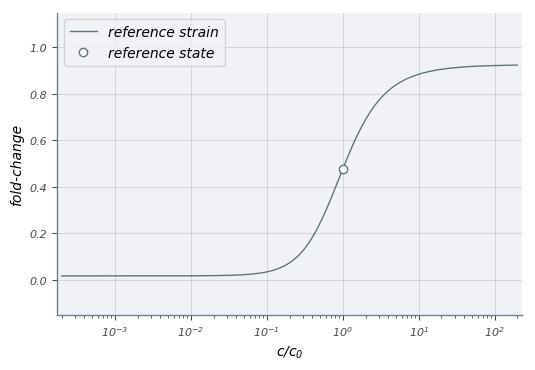

In [4]:
# Define the reference parameters. 
R0 = constants['RBS1027'] 
c0 = 50 # in µM
epRA = constants['O2']
ref_state = mut.thermo.SimpleRepression(R=R0, effector_conc=c0, 
                                       ep_r=epRA, ka=constants['Ka'],
                                       ki=constants['Ki'], ep_ai=constants['ep_AI'],
                                       n_sites=constants['n_sites'])

# Define the reference strain (i.e. wild-typel)
c_range = np.logspace(-2, 4, 200) # in µM
ref_strain = mut.thermo.SimpleRepression(R=R0, effector_conc=c_range, 
                                       ep_r=epRA, ka=constants['Ka'],
                                       ki=constants['Ki'], ep_ai=constants['ep_AI'],
                                       n_sites=constants['n_sites'])

# Instantiate the figure
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.set_xscale('log')
ax.set_xlabel('$c / c_0$', fontsize=10)
ax.set_ylabel('fold-change', fontsize=10)
ax.set_ylim([-0.15, 1.15])

# Plot the reference strain and state. 
ax.plot(c_range / c0, ref_strain.fold_change(), '-', lw=1, color=colors[0], 
           label='reference strain')
ax.plot(c0 / c0, ref_state.fold_change(), 'o', markerfacecolor='w', color=colors[0], 
           label='reference state')
ax.legend(fontsize=10)

## Part I: DNA Binding Domain Mutation

Given a mutation in the DNA binding domain, what biophysical parameters are changed? Is it *only* the DNA binding energy, or do other biophysical parameters change in response? Here, we have three differen mutations in the DNA binding domain (Y20I, Q21A, and Q21M) which alter *at least* the affinity of the repressor to the DNA.  

To begin, we can examine induction profiles relative to the reference state and strain shown above

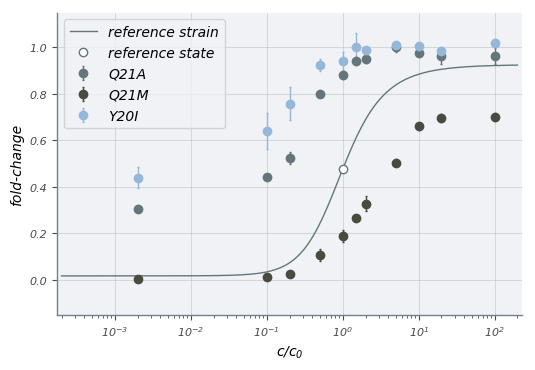

In [5]:
# Isolate the data to DNA binding mutations
DNA = data[(data['class']=='DNA') & (data['operator']=='O2') &
          (data['repressors']==260)].copy()

# Group them by IPTG and compute the aggregate props. 
grouped = DNA.groupby(['mutant', 'IPTGuM']).agg(('mean', 'sem')).reset_index()

# Instantiate the figure
fig, ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.set_xscale('log')
ax.set_xlabel('$c / c_0$', fontsize=10)
ax.set_ylabel('fold-change', fontsize=10)
ax.set_ylim([-0.15, 1.15])

# Plot the reference strain and state. 
ax.plot(c_range / c0, ref_strain.fold_change(), lw=1, color=colors[0], 
           label='reference strain')
ax.plot(c0 / c0, ref_state.fold_change(), 'o', markerfacecolor='w', color=colors[0], 
           label='reference state')
for g, d in grouped.groupby('mutant'):
    ax.errorbar(d['IPTGuM']/c0, d['fold_change']['mean'], d['fold_change']['sem'],
               fmt='o', linestyle='none', lw=1, capsize=1, label=g)
ax.legend(fontsize=10)

These mutants are distinctly different than the reference strain. However, it is not possible to identify which parameters are changing just from looking at the curves relative to the reference strain. However, if the difference is *only* in the DNA binding energy $\Delta\varepsilon_{RA}$, the difference in the free energy of binding should be constant and independent of inducer concentration. The empirical $\Delta F$ can be directly calcuated from the fold-change measurements,

$$
\Delta F^* = F_0 - \log\left({1 \over \text{fold-change}} - 1\right),
$$

This immediately reveals an issue $--$ while theoretically the fold-change is restricted to $[0, 1]$ experimental measurements can go beyond these bounds thanks to mesurement error. Therefore, it is not possible to compute $\Delta F^*$ without neglecting some of the data. Nevertheless, we can continue along our merry way and see how it all works out. 

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':


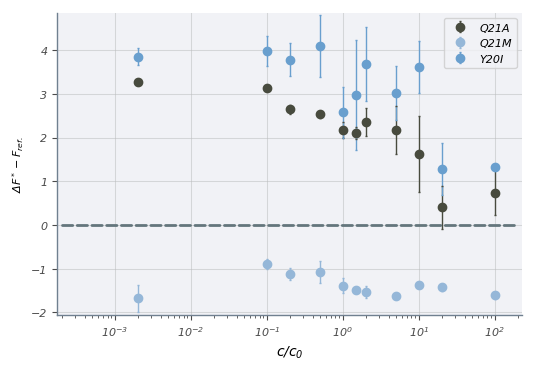

In [21]:
# Compute the reference state at the same inducer concentrations. 
_ref_strain = mut.thermo.SimpleRepression(R=260, ep_r=constants['O2'],
                                        effector_conc=DNA['IPTGuM'],
                                        ep_ai=constants['ep_AI'],
                                        ka=constants['Ka'], ki=constants['Ki'], 
                                        n_sites=constants['n_sites'])

# Compute the empirical delta F from the experimental measurements. 
DNA['empirical_F'] = -ref_state.bohr_parameter() - np.log((1 / DNA['fold_change']) - 1)

# Compute the change in the free energy of binding. 
DNA['empirical_ddf'] = DNA['empirical_F'] - (-ref_state.bohr_parameter() + _ref_strain.bohr_parameter())

# Group by the inducer concentration and mutant, and compute the mean + sem.
grouped = DNA.groupby(['mutant', 'IPTGuM'])['empirical_ddf'].agg(('mean', 'sem')).reset_index()

# Instantiate the figure. 
fig, ax = plt.subplots(1, 1, figsize=(6, 4), dpi=100)
ax.set_xlabel('$c / c_0$', fontsize=10)
ax.set_ylabel('$\Delta F^* - F_\mathrm{ref.}$')
ax.set_xscale('log')

# Plot the zero 
ax.plot(np.array([1E-2, 1E4]) / c0, [0, 0], '--', label='__nolegend__')

# iterate through the computed ddf and plot. 
for g, d in grouped.groupby(['mutant']):
    ax.errorbar(d['IPTGuM'] / c0, d['mean'], d['sem'], lw=1, capsize=1, label=g,
               linestyle='none', fmt='o')
ax.legend()

Q21M appears to be constant (within noise, at least), but Q21A and Y20I show some dependence on concentration. HOwever, I'm not convinced that's actually the case. By calculating the empirical ∆F *directly* from data, we are tossing data that is above 1 or below zero. Thus, we are really only computing the average of tails.

In this sense, I think it would be more fair to accurately characterize the induction profiles of each of these mutants using a Hill function then computing the empirical ∆F across a continuum of concentrations, rather than examining the data directly. 

### Fitting the DNA Mutants with Hill Function

The Hill function for the induction profile has the form. 
$$
\text{fold-change} = a + b{1 \over 1 + \left({K_D \over c}\right)^n},
$$
where $a$ is the leakiness, $b$ is the dynamic range, $c$ is the inducer concentration, and $K_D$ is the generalized dissociation constant for the repressor to the DNA. 

Given our induction data, we can estimate $a$, $b$, and $K_D$ using Bayesian inferential methods. Using Bayes' theorem, our posterior probability distribution can be written as

$$
g(a, b, K_D, n\vert c, \mathbf{D}) \propto f(\mathbf{D}\vert a, b, K_D)g(a, b, K_D, n)
$$

where $g$ and $f$ correspond to probability densities over parameters and data, respectively. I believe it is fair to take the likelihood as a normal distribution with mean µ and standard deviation σ,

$$
f(\mathbf{D}\vert a, b, K_D) \sim \text{Normal}(\mu, \sigma)\forall i\in D.
$$

For prior distributions $a$, and $b$ can be uniform on the range 0 to 1 as they are bounded and limited therein by the theory,

$$
g(a) \sim \text{Uniform}(0, 1); g(b) \sim \text{Uniform}(0, 1).
$$

For $K_D$, its better to sample in the log space,

$$
\Delta\varepsilon_D = k_BT \log {K_D \over 1\,\mu\mathrm{M}},
$$

where the prior can be centered at zero,

$$
g(\Delta\varepsilon_D) \sim \text{Normal}(0, 5).
$$

For $\sigma$, my experience and knowledge about the limitations of measurement says a prior choice of HalfNormal is resonable with a small-ish standard deviation,

$$
g(\sigma) \sim \text{HalfNormal}(0, 0.1),
$$

is reasonable. 

We can code this statistical model up in Stan and sample for all three of our mutations. 

In [58]:
%%stan -v hill_fitting

data {
    int<lower=1> N; // Number of data points. 
    vector<lower=0>[N] c; // Inducer concentration in uM
    vector[N] fc; // Observed fold-change
}

parameters {
    real<lower=0, upper=1> a; // Leakiness parameter
    real<lower=0, upper=1> b; // Dynamic range parameter
    real<lower=0> Kd; // Dissociation constant
    real n;
    real<lower=0> sigma; // Homoscedastic error
}

transformed parameters {
    // Log transform Kd
    real ep_a = log(Kd); // in kBT
}

model {
    //Define a vector to store the theoretical value. 
    vector[N] mu;
    
    // Define the priors
    a ~ uniform(0, 1);
    b ~ uniform(0, 1);
    n ~ normal(0, 10);
    Kd ~ normal(0, 100);
    sigma ~ normal(0, 0.1);
    
    // Compute the theoretical value from parameters
    for (i in 1:N) {
        mu[i] = a + b *  (c[i]/ Kd)^n / (1 + (c[i] / Kd)^n);
        fc[i] ~ normal(mu[i], sigma);
    } 
}


Using pystan.stanc compiler..
-------------------------------------------------------------------------------
Model compiled successfully. Output stored in hill_fitting object.
Type hill_fitting in a cell to see a nicely formatted code output in a notebook
     ^^^^^^^^^^^^
Access model compile output properties
hill_fitting.model_file -> Name of stan_file [None]
hill_fitting.model_name -> Name of stan model [None]
hill_fitting.model_code -> Model code [ data {     int<lowe ....]


In [59]:
# Load the model into pystan
model = pystan.StanModel(model_code=hill_fitting.model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_bf61be4cad6ff8a680fbd3f085c276be NOW.
/anaconda3/lib/python3.6/site-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /var/folders/2q/lvh2zsws3lxckq8xtkn_84z80000gn/T/tmpjps4wxw9/stanfit4anon_model_bf61be4cad6ff8a680fbd3f085c276be_6339466580726574400.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


In [126]:
# Instantiate the storage dataframes for the sampling. 
sample_dfs = []
summary_dfs = []

# Iterate through the mutants and perform the inference
for g, d in DNA.groupby(['mutant']):
    data_dict = {'N':len(d), 'fc':d['fold_change'], 'c':d['IPTGuM']}
    samples = model.sampling(data_dict)
    samples_df = samples.to_dataframe()
    
    # Add identifying information to output
    samples_df['mutant'] = g
    sample_dfs.append(samples_df)
    
    # Compute the summary statistics.
    _df = pd.DataFrame([], columns=['parameter', 'param_median', 'hpd_min', 'hpd_max'])
    for p in samples.unconstrained_param_names():
        p_median = np.median(samples_df[p])
        hpd_min, hpd_max = mut.stats.compute_hpd(samples_df[p], 0.95)
        _df = _df.append({'parameter': p, 'param_median':p_median, 'hpd_min':hpd_min, 'hpd_max':hpd_max},
                        ignore_index=True)
    _df['mutant'] = g
    summary_dfs.append(_df)
    
# Concatenate the dataframes for easy parsing. 
sample_df = pd.concat(sample_dfs)    
summary_df = pd.concat(summary_dfs)

The inference is *very* fast (around 450 µs per mutant). Let's look at the distributions of each parameter. 

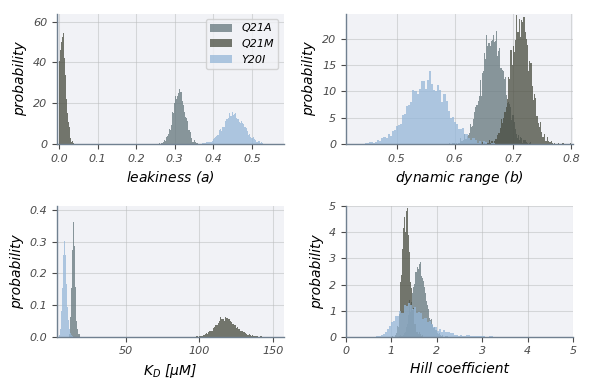

In [127]:
# Instantiate the figure
fig, ax = plt.subplots(2, 2)
ax = ax.ravel() 

# Format and label the axes. 
ax[0].set_xlabel('leakiness ($a$)', fontsize=10)
ax[1].set_xlabel('dynamic range ($b$)', fontsize=10)
ax[2].set_xlabel('$K_D$ [µM]', fontsize=10)
ax[3].set_xlabel('Hill coefficient', fontsize=10)
for a in ax:
    a.set_ylabel('probability', fontsize=10)

for g, d in sample_df.groupby(['mutant']):
    ax[0].hist(d['a'], bins=75, histtype='stepfilled', alpha=0.75,
              density=True, label=g)
    ax[1].hist(d['b'], bins=75, histtype='stepfilled', alpha=0.75,
              density=True, label=g)
    ax[2].hist(d['Kd'], bins=75, histtype='stepfilled', alpha=0.75,
              density=True, label=g)      
    ax[3].hist(d['n'], bins=75, histtype='stepfilled', alpha=0.75,
              density=True, label=g)      

# Add legend
ax[0].legend()
ax[-1].set_xlim([0, 5])
plt.tight_layout()

The sample look good with all distributions being *mostly* symmetric. It looks like the Hill coefficient for Y20I is heavy tailed.

Using this sampling, let's plot the 95% credible region for each fit over the induction profiles. 

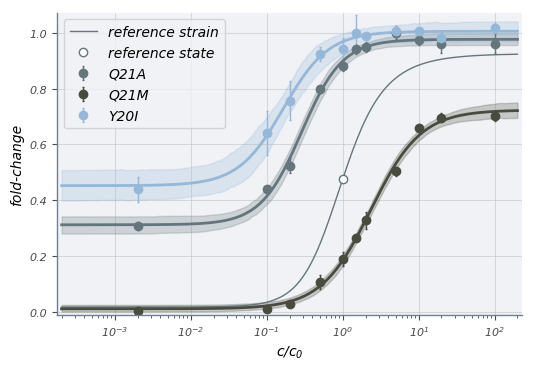

In [128]:
# Define the Hill function
def hill_function(c_range, params):
    a, b, kd, n = params
    return a + b * (c_range/kd)**n / (1 + (c_range/kd)**n)

# Group the induction profiles for easy plotting
grouped = DNA.groupby(['mutant', 'IPTGuM']).agg(('mean', 'sem')).reset_index()

# Instantiate the figure.
fig, ax = plt.subplots(1,1, figsize=(6, 4))
ax.set_xscale('log')
ax.set_xlabel('$ c / c_0$', fontsize=10)
ax.set_ylabel('fold-change', fontsize=10)

# Plot the induction profiles. 
ax.plot(c_range / c0, ref_strain.fold_change(), lw=1, color=colors[0], 
           label='reference strain')
ax.plot(c0 / c0, ref_state.fold_change(), 'o', markerfacecolor='w', color=colors[0], 
           label='reference state')
for g, d in grouped.groupby('mutant'):
    ax.errorbar(d['IPTGuM']/c0, d['fold_change']['mean'], d['fold_change']['sem'],
               fmt='o', linestyle='none', lw=1, capsize=1, label=g)
ax.legend(fontsize=10)


# Plot the credible regions
_colors = {'Q21A': colors[0], 'Q21M': colors[1], 'Y20I':colors[2]}
for g, d in sample_df.groupby('mutant'):
    # Instantiate the credible region bounds. 
    cred_region = np.zeros((2, len(c_range)))
    for i, c in enumerate(c_range):  
        hill = d['a'] + d['b'] * (c / d['Kd'])**d['n'] / (1 + (c /d['Kd'])**d['n'])
        cred_region[:, i] = mut.stats.compute_hpd(hill, 0.95)
    # Plot the credible regions. 
    ax.fill_between(c_range / c0, cred_region[0, :], cred_region[1, :], color=_colors[g],
                   alpha=0.25, label='__nolegend__', zorder=1)
    
# Plot the median curves. 
for g, d in summary_df.groupby('mutant'): 
    # Extract the parameters
    a, b, Kd, n, _ = d['param_median'].values
    hill = hill_function(c_range, (a, b, Kd, n))
    ax.plot(c_range / c0, hill, color=_colors[g]) 

 These fits look pretty reliable and with reasonably narrow credible regions. Given these parameters, we can compute the empirical ∆F. Note that for Y20I, the hill fit of the fold-change still exceeds 1.0. We will need to just drop those positions as needed.


In [227]:
# Set up the empirical data frame. 
empirical_dfs = []

for g, d in summary_df.groupby(['mutant']):
    # Parse the parameters. 
    a, b, Kd, n, _ = d['param_median']
    hill = hill_function(c_range, (a, b, Kd, n))
    
    # Compute the ddf
    measured_F = np.log((1/ hill) - 1)
    delta_F = -ref_state.bohr_parameter() - measured_F
    delta_delta_F = delta_F - (-ref_state.bohr_parameter() + ref_strain.bohr_parameter()) 
    
    # Generate the dataframe. 
    df = pd.DataFrame(np.array([c_range, measured_F, delta_F, delta_delta_F]).T,
                     columns=['IPTGuM', 'measured_F', 'empirical_deltaF', 'ddf'])
    df['mutant'] = g
    empirical_dfs.append(df)
empirical_df = pd.concat(empirical_dfs)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in log
  # Remove the CWD from sys.path while we load stuff.


With the dat arame put together, we can plot ∆∆F.  

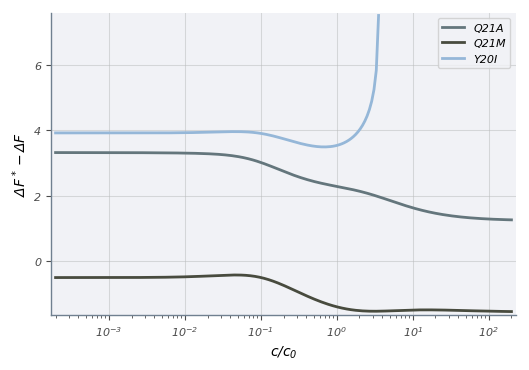

In [229]:
# Generate the DDF plot
fig, ax = plt.subplots(1,1, figsize=(6, 4))
for g, d in empirical_df.groupby('mutant'):
    ax.plot(d['IPTGuM'] / c0, d['ddf'], '-', label=g)
    
ax.set_xscale('log')
ax.set_xlabel('$c/c_0$', fontsize=10)
ax.set_ylabel('$\Delta F^* - \Delta F$', fontsize=10)
ax.legend()